In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import audio_tagging_utils as utils
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from tensorflow.python.client import device_lib
import tensorflow.keras.backend as K
import gc
from sklearn import metrics
from sklearn.model_selection import KFold

# This is needed to get if the gpu is detected, as we carried out runs on our local machines.
# print(device_lib.list_local_devices())

A CNN within our project will be fed the spectrograms of the .wav as input images. Such images need to be generated first, this is carried out by calling a method defined in the utility file. Such method will fetch each .wav present in the input directory and traspose it to its corresponding spectrogram, saving it as a .jpg image. The project relied a lot on os.path.join as to make paths os agnostic.


In [2]:
traindf_dir = os.path.join('meta', 'train.csv')
testdf_dir = os.path.join('meta', 'test.csv')
train_path = os.path.join('images', 'train')
test_path = os.path.join('images', 'test')
number_of_splits = 10
number_of_classes = 41

if not os.path.exists('runs'):
    os.mkdir('runs')

if not os.path.exists('images'):
    os.mkdir('images')

if not os.path.exists(train_path):
    os.mkdir(train_path)

if not os.path.exists(test_path):
    os.mkdir(test_path)

if not len(glob(os.path.join(train_path, '*'))) == 9473:
    utils.create_images('train', 'train')

if not len(glob(os.path.join(test_path, '*'))) == 1600:
    utils.create_images('test', 'test')

As the code aim to be highly modular, each employed model is defined as a method, this makes the Notebook more organic and readable, as each model is encapsulated. 

In [3]:
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.python.keras.engine import training
from tensorflow.python.framework.ops import Tensor
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, LeakyReLU, Conv2D, MaxPooling2D, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def spectrogram_2d_conv_pool_cnn(model_input: Tensor) -> training.Model:
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(model_input)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)
    
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(number_of_classes, activation='softmax')(x)

    model = Model(model_input, x, name='spectrogram_2d_conv_pool_cnn')
    model.compile(optimizers.Adam(0.001),loss="categorical_crossentropy",metrics=['accuracy'])
    
    return model

def kaggle_2d_conv_pool_cnn(model_input: Tensor) -> training.Model:
    x = Conv2D(32, (4,10), padding="same")(model_input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dense(number_of_classes, activation='softmax')(x)
    
    model = Model(model_input, x, name='kaggle_2d_conv_pool_cnn')
    model.compile(optimizers.Adam(0.0001),loss="categorical_crossentropy",metrics=['accuracy'])
    
    return model

def kaggle_1d_conv_pool_cnn(model_input: Tensor) -> training.Model:
    x = Conv1D(16, 9, activation='relu', padding="valid")(model_input)
    x = Conv1D(16, 9, activation='relu', padding="valid")(x)
    x = MaxPooling1D(16)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Conv1D(32, 3, activation='relu', padding="valid")(x)
    x = Conv1D(32, 3, activation='relu', padding="valid")(x)
    x = MaxPooling1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Conv1D(32, 3, activation='relu', padding="valid")(x)
    x = Conv1D(32, 3, activation='relu', padding="valid")(x)
    x = MaxPooling1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Conv1D(256, 3, activation='relu', padding="valid")(x)
    x = Conv1D(256, 3, activation='relu', padding="valid")(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(rate=0.2)(x)

    x = Dense(64, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(number_of_classes, activation='softmax')(x)
    
    model = Model(model_input, x, name='kaggle_1d_conv_pool_cnn')
    model.compile(optimizers.Adam(0.001),loss="categorical_crossentropy",metrics=['accuracy'])
    
    return model


def lstm(model_input: Tensor) -> training.Model:
    x = LSTM(1028, activation='relu')(model_input)
    x = Dense(64, activation='relu')(x)
    x = Dense(number_of_classes, activation='softmax')(x)
    
    model = Model(model_input, x, name='lstm')
    model.compile(optimizers.Adam(0.001),loss="categorical_crossentropy",metrics=['accuracy'])
    
    return model

Now it is time to set up our trainining and evaluation pipeline for the model employing the .jpg spectrograms. The pipeline implement Kfold validation during training and evaluate each model on the test set, as well as generating its predictions using the best model obtained, as the best weights are saved during training.

In [4]:
# Shape of the input to the CNN, this shape is obtained from the flow_from_dataset method implemented in the next cell.
model_input = Input(shape=(64, 64, 3))
spectrogram_2d_model = spectrogram_2d_conv_pool_cnn(model_input)
spectrogram_2d_model.summary()

# We generate a folder for each model, this allows for a clear separation of the runs. Allowing for a cleaner folder structure.
# The other folders are generated in the cells below
run_dir = os.path.join('runs', spectrogram_2d_model.name)
if not os.path.exists(run_dir):
    os.mkdir(run_dir)
if os.path.exists(os.path.join(run_dir, 'logs')):
    shutil.rmtree(os.path.join(run_dir, 'logs'))
    
traindf=pd.read_csv(traindf_dir)
testdf=pd.read_csv(testdf_dir)    

# As the datasets have .wav, they need to be modified to search for .jpg files
traindf["fname"]= traindf["fname"].apply(utils.append_ext)
testdf["fname"]= testdf["fname"].apply(utils.append_ext)

Model: "spectrogram_2d_conv_pool_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29

+-----------Training spectrogram_2d_conv_pool_cnn Model-----------+
Found 7578 validated image filenames belonging to 41 classes.
Found 1895 validated image filenames belonging to 41 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 236 steps, validate for 59 steps
Epoch 1/25
235/236 [============================>.] - ETA: 0s - loss: 3.1649 - accuracy: 0.1304
Epoch 00001: val_loss improved from inf to 2.62585, saving model to runs\spectrogram_2d_conv_pool_cnn\best_0.h5
236/236 [==============================] - 21s 88ms/step - loss: 3.1627 - accuracy: 0.1311 - val_loss: 2.6258 - val_accuracy: 0.2606
Epoch 2/25
235/236 [============================>.] - ETA: 0s - loss: 2.4517 - accuracy: 0.2887
Epoch 00002: val_loss improved from 2.62585 to 2.03925, saving model to runs\spectrogram_2d_conv_pool_cnn\best_0.h5
236/236 [==============================] - 13s 55ms/step - loss: 2.4501 - accuracy: 0.2892 - val_loss: 2.0393 - val_accuracy: 0.4311
Epoch 3/25
235/236 [=========

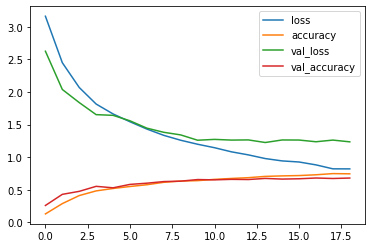

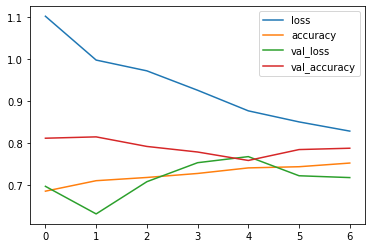

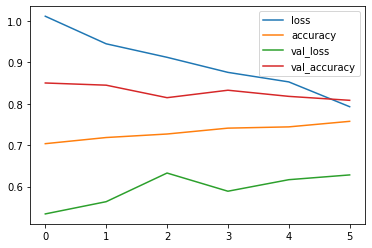

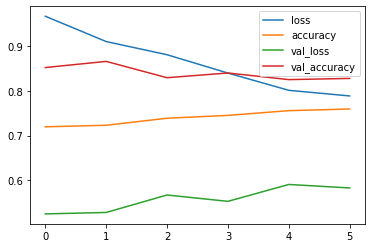

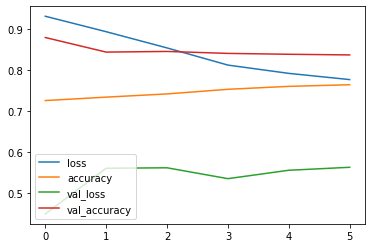

In [5]:
datagen=ImageDataGenerator(rescale=1./255.)

# The class indices to encode the labels need to be static(if not, ensemble of predictiosn will not be correct)
class_indices = {}

kfold_validation = KFold(n_splits= number_of_splits, shuffle=True, random_state=42)

# This structure is based on the one followed by the Kaggle notebook: https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data
#Using random_state = 42 for repeatibility
print(f'+-----------Training {spectrogram_2d_model.name} Model-----------+')
for i, (train_split_indexes, test_split_indexes) in enumerate(kfold_validation.split(traindf)):
    train_fold = traindf.iloc[train_split_indexes]
    val_fold = traindf.iloc[test_split_indexes]

    best_weights_file = os.path.join(run_dir, f'best_{i}.h5')
    checkpoint = ModelCheckpoint(best_weights_file, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir= os.path.join(run_dir, 'logs', f'fold_{i}'), write_graph=True)

    callbacks_list = [checkpoint, early, tb]

    # flow_from_dataframe is useful as it generates the bitstreams to pass to the model give the image folder and reference dataframe
    train_generator=datagen.flow_from_dataframe(
        dataframe=train_fold,
        directory=os.path.join('images', 'train'),
        x_col="fname",
        y_col="label",
        batch_size=32,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=(64,64))

    valid_generator=datagen.flow_from_dataframe(
        dataframe=val_fold,
        directory=os.path.join('images', 'train'),
        x_col="fname",
        y_col="label",
        batch_size=32,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=(64,64))

    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

    spectrogram_2d_model.fit(train_generator,
                    callbacks=callbacks_list,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25)

    spectrogram_2d_model.load_weights(best_weights_file)
    
    train_generator.reset()
    valid_generator.reset()
    
    eval_generator=datagen.flow_from_dataframe(
        dataframe=testdf,
        directory=os.path.join('images', 'test'),
        x_col="fname",
        y_col= "label",
        batch_size=32,
        seed=42,
        shuffle=False,
        class_mode="categorical",
        target_size=(64,64))

    STEP_SIZE_EVAL=eval_generator.n//eval_generator.batch_size

    # It is important to reset the generator before evaluation
    eval_generator.reset()
    
    spectrogram_2d_model.evaluate(eval_generator, steps=STEP_SIZE_EVAL, verbose= 1)
    
    test_generator=datagen.flow_from_dataframe(
        dataframe=testdf,
        directory=os.path.join('images', 'test'),
        x_col="fname",
        y_col= None,
        batch_size=32,
        seed=42,
        shuffle=False,
        class_mode= None,
        target_size=(64,64))
    
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
    
    test_generator.reset()
    
    pred = spectrogram_2d_model.predict(test_generator, steps=STEP_SIZE_TEST, verbose= 1)
    
    np.save(os.path.join(run_dir, f'test_predictions_{i}.npy'), pred)
    
    pd.DataFrame(spectrogram_2d_model.history.history).plot()
    
    #On last step, retrieve actual class_indices, this is used to retrieve the actual string labels
    if i == number_of_splits - 1:
        class_indices = train_generator.class_indices

In [6]:
#Ensembling of the predictions using geometric average
pred_list = []
for i in range(number_of_splits):
    pred_list.append(np.load(os.path.join(run_dir, f'test_predictions_{i}.npy')))

prediction = np.ones_like(pred_list[0])

for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))

#Saving predictions
predicted_class_indices = np.argmax(prediction,axis=-1)

#Classes need to be retrieved using the class_indices used by the train generators, for simplicity, the class indices will be used to the other two models.
labels = dict((v,k) for k,v in class_indices.items())
predicted_labels = [labels[k] for k in predicted_class_indices]

test = pd.read_csv(testdf_dir)

test[['fname', 'label']].to_csv(os.path.join(run_dir, f'{spectrogram_2d_model.name}_predictions.csv'), index=False)

y_true = test['label']
y_pred = predicted_labels

print(f'+-----------Printing {spectrogram_2d_model.name} predictions evaluations-----------+')
print(metrics.classification_report(y_true, y_pred, digits=3))

+-----------Printing spectrogram_2d_conv_pool_cnn predictions evaluations-----------+
                       precision    recall  f1-score   support

      Acoustic_guitar      0.795     0.778     0.787        45
             Applause      0.865     1.000     0.928        32
                 Bark      0.821     0.821     0.821        28
            Bass_drum      0.871     0.964     0.915        28
Burping_or_eructation      0.939     0.969     0.954        32
                  Bus      0.857     0.480     0.615        25
                Cello      0.830     0.815     0.822        54
                Chime      0.810     0.586     0.680        29
             Clarinet      0.797     0.839     0.817        56
    Computer_keyboard      0.462     0.231     0.308        26
                Cough      0.600     0.800     0.686        30
              Cowbell      0.974     0.905     0.938        42
          Double_bass      0.857     0.900     0.878        40
 Drawer_open_or_close      0.80

Now we will train two different models. One uses the Mfcc transformation (kaggle_2d) and the other uses the raw .wav files(kaggle_1d)
The two models uses different sampling rate to generate the encodings. This is necessary due to mfcc requiring a higher sampling rate to produce good enough results.

In [7]:
max_len = 2
n_mfcc = 40

#raw .wav and mfcc are obtained using different sample rates, we followed the values used on the Kaggle notebook previously cited.
kaggle_2d_sr = 44100
base_sr = 16000

lstm_seed = 3
kaggle_2d_seed = 2
kaggle_1d_seed = 1

#Model declaration
model_input = Input(shape=utils.mfcc_input_sizes(n_mfcc, kaggle_2d_sr, max_len))
kaggle_2d_model = kaggle_2d_conv_pool_cnn(model_input) 


model_input = Input(shape=utils.wav_input_sizes(base_sr, max_len))
kaggle_1d_model = kaggle_1d_conv_pool_cnn(model_input) 

model_input = Input(shape=utils.mfcc_compressed_input_sizes(n_mfcc, max_len))
lstm_model = lstm(model_input) 

kaggle_1d_run_dir = os.path.join('runs', kaggle_1d_model.name)

if not os.path.exists(kaggle_1d_run_dir):
    os.mkdir(kaggle_1d_run_dir)
if os.path.exists(os.path.join(kaggle_1d_run_dir, 'logs')):
    shutil.rmtree(os.path.join(kaggle_1d_run_dir, 'logs'))
    
kaggle_2d_run_dir = os.path.join('runs', kaggle_2d_model.name)

if not os.path.exists(kaggle_2d_run_dir):
    os.mkdir(kaggle_2d_run_dir)
if os.path.exists(os.path.join(kaggle_2d_run_dir, 'logs')):
    shutil.rmtree(os.path.join(kaggle_2d_run_dir, 'logs'))

lstm_run_dir = os.path.join('runs', lstm_model.name)

if not os.path.exists(lstm_run_dir):
    os.mkdir(lstm_run_dir)
if os.path.exists(os.path.join(lstm_run_dir, 'logs')):
    shutil.rmtree(os.path.join(lstm_run_dir, 'logs'))
    
#Feeding the models into a list will make the code more modular.
models_to_train = [kaggle_2d_model, kaggle_1d_model, lstm_model]

#Re-read the dataframes, as .jpg was appended to 'fname'
traindf=pd.read_csv(traindf_dir)
testdf=pd.read_csv(testdf_dir)

Model: "kaggle_2d_conv_pool_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40, 173, 1)]      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 40, 173, 32)       1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 173, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 40, 173, 32)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 86, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 86, 32)        40992     
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 86,

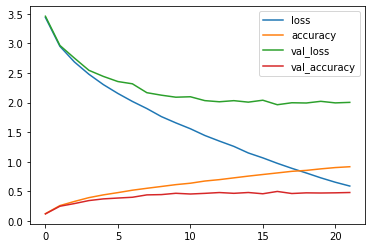

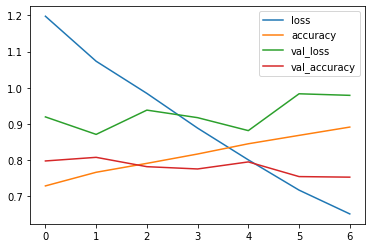

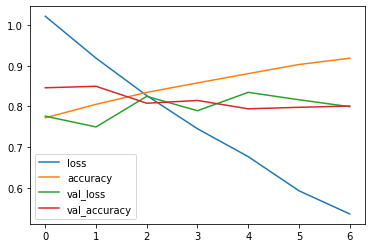

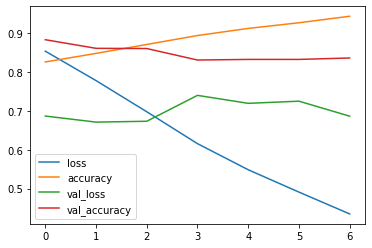

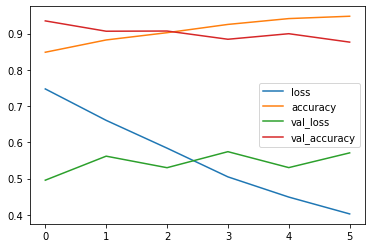

In [8]:
kfold_validation = KFold(n_splits= number_of_splits, shuffle=True, random_state=kaggle_2d_seed)
# Although this makes the code looks ugly, it allows for better testability and repetibility

kaggle_2d_model.summary()

run_dir = os.path.join('runs', kaggle_2d_model.name)
test_data = os.path.join(run_dir, 'test_input_labels.npz')
train_data = os.path.join(run_dir, 'train_input_labels.npz')

if not os.path.exists(test_data) :
    X_test, y_test = utils.create_mfcc_array(testdf, 'test', sr= kaggle_2d_sr, max_len= max_len, n_mfcc= n_mfcc)
    np.savez(test_data, x_test=X_test, y_test=y_test)
if os.path.exists(test_data):
    test_arrays = np.load(test_data)
    
if not os.path.exists(train_data) :
    X, y = utils.create_mfcc_array(traindf, 'train', sr= kaggle_2d_sr, max_len= max_len, n_mfcc= n_mfcc)
    np.savez(train_data, x=X, y=y)
if os.path.exists(train_data):
    train_arrays = np.load(train_data)
    
#The models uses different input shapes
input_shape = utils.mfcc_input_sizes(n_mfcc, kaggle_2d_sr, max_len)

#Using random_state = 0 for repeatibility
print(f'+-----------Training {kaggle_2d_model.name} Model-----------+')
for i, (train_split_indexes, validation_split_indexes) in enumerate(kfold_validation.split(traindf)):
    #Loading all necessary arrays
    X, y = train_arrays['x'], train_arrays['y']
    X_test, y_test = test_arrays['x_test'], test_arrays['y_test']
    X_train, y_train = X[train_split_indexes], y[train_split_indexes]
    X_val, y_val = X[validation_split_indexes], y[validation_split_indexes]
    
    best_weights_file = os.path.join(run_dir, f'best_{i}.h5')
    checkpoint = ModelCheckpoint(best_weights_file, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir= os.path.join(run_dir, 'logs', f'fold_{i}'), write_graph=True)

    callbacks_list = [checkpoint, early, tb]

    #Outputs are generated using consistend indices
    y_train, y_val = pd.Series(y_train).apply(lambda x: class_indices[x]), pd.Series(y_val).apply(lambda x: class_indices[x])
    X_train, X_val = X_train.reshape(X_train.shape[0], input_shape[0], input_shape[1], input_shape[2]), X_val.reshape(X_val.shape[0], input_shape[0], input_shape[1], input_shape[2])
    y_test = pd.Series(y_test).apply(lambda x: class_indices[x])
    X_test = X_test.reshape(X_test.shape[0], input_shape[0], input_shape[1], input_shape[2])
    
    #Very important data normalization.
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    
    #Normalizing sets using the X_train's value, it is important to use the X_train normalization values
    X_train, X_val, X_test = (X_train - mean)/std, (X_val - mean)/std, (X_test - mean)/std
    
    # Creating class matrix
    y_train_hot = to_categorical(y_train)
    y_val_hot = to_categorical(y_val)
    y_test_hot = to_categorical(y_test)
    
    kaggle_2d_model.fit(X_train, y_train_hot,
                callbacks=callbacks_list,
                validation_data=(X_val, y_val_hot),
                epochs=25)
    
    kaggle_2d_model.load_weights(best_weights_file)
    
    kaggle_2d_model.evaluate(X_test, y_test_hot)
    
    pred = kaggle_2d_model.predict(X_test, verbose= 1)

    np.save(os.path.join(run_dir, f'test_predictions_{i}.npy'), pred)
    
    pd.DataFrame(kaggle_2d_model.history.history).plot()

Model: "kaggle_1d_conv_pool_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32000, 1)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 31992, 16)         160       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 31984, 16)         2320      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1999, 16)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1999, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1997, 32)          1568      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1995, 3

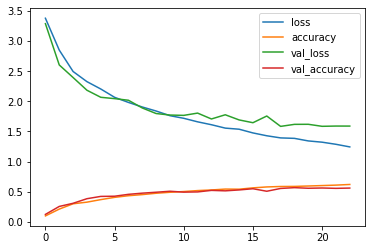

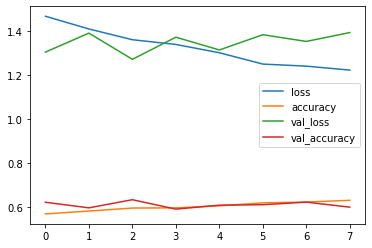

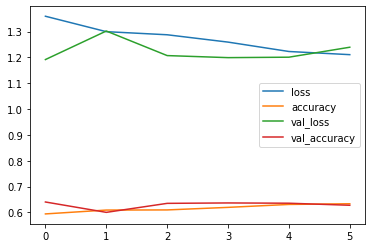

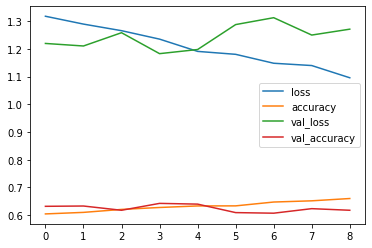

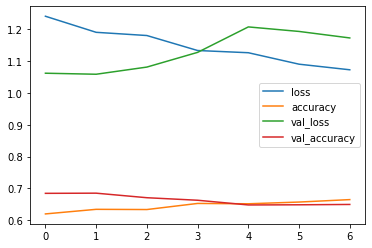

In [9]:
kfold_validation = KFold(n_splits= number_of_splits, shuffle=True, random_state=kaggle_1d_seed)

kaggle_1d_model.summary()

run_dir = os.path.join('runs', kaggle_1d_model.name)
test_data = os.path.join(run_dir, 'test_input_labels.npz')
train_data = os.path.join(run_dir, 'train_input_labels.npz')

if not os.path.exists(test_data) :
    X_test, y_test = utils.create_wav_array(testdf, 'test', sr= base_sr, max_len= max_len)
    np.savez(test_data, x_test=X_test, y_test=y_test)
if os.path.exists(test_data):
    test_arrays = np.load(test_data)
    
if not os.path.exists(train_data) :
    X, y = utils.create_wav_array(traindf, 'train', sr= base_sr, max_len= max_len)
    np.savez(train_data, x=X, y=y)
if os.path.exists(train_data):
    train_arrays = np.load(train_data)
    
input_shape = utils.wav_input_sizes(base_sr, max_len)

print(f'+-----------Training {kaggle_1d_model.name} Model-----------+')
for i, (train_split_indexes, validation_split_indexes) in enumerate(kfold_validation.split(traindf)):
    X, y = train_arrays['x'], train_arrays['y']
    X_test, y_test = test_arrays['x_test'], test_arrays['y_test']
    X_train, y_train = X[train_split_indexes], y[train_split_indexes]
    X_val, y_val = X[validation_split_indexes], y[validation_split_indexes]
    
    best_weights_file = os.path.join(run_dir, f'best_{i}.h5')
    checkpoint = ModelCheckpoint(best_weights_file, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir= os.path.join(run_dir, 'logs', f'fold_{i}'), write_graph=True)

    callbacks_list = [checkpoint, early, tb]

    y_train, y_val = pd.Series(y_train).apply(lambda x: class_indices[x]), pd.Series(y_val).apply(lambda x: class_indices[x])
    X_train, X_val = X_train.reshape(X_train.shape[0], input_shape[0], input_shape[1]), X_val.reshape(X_val.shape[0], input_shape[0], input_shape[1])
    y_test = pd.Series(y_test).apply(lambda x: class_indices[x])
    X_test= X_test.reshape(X_test.shape[0], input_shape[0], input_shape[1])
    
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    
    X_train, X_val, X_test = (X_train - mean)/std, (X_val - mean)/std, (X_test - mean)/std
    
    y_train_hot = to_categorical(y_train)
    y_val_hot = to_categorical(y_val)
    y_test_hot = to_categorical(y_test)
    
    kaggle_1d_model.fit(X_train, y_train_hot,
                callbacks=callbacks_list,
                validation_data=(X_val, y_val_hot),
                epochs=25)
    
    kaggle_1d_model.load_weights(best_weights_file)
    
    kaggle_1d_model.evaluate(X_test, y_test_hot)
    
    pred = kaggle_1d_model.predict(X_test, verbose= 1)

    np.save(os.path.join(run_dir, f'test_predictions_{i}.npy'), pred)
    
    pd.DataFrame(kaggle_1d_model.history.history).plot()

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 40, 2)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1028)              4239472   
_________________________________________________________________
dense_7 (Dense)              (None, 64)                65856     
_________________________________________________________________
dense_8 (Dense)              (None, 41)                2665      
Total params: 4,307,993
Trainable params: 4,307,993
Non-trainable params: 0
_________________________________________________________________
+-----------Training lstm Model-----------+
Train on 7578 samples, validate on 1895 samples
Epoch 1/50
7552/7578 [============================>.] - ETA: 0s - loss: 4.3071 - accuracy: 0.0358
Epoch 00001: val_loss improved from inf to 3.65634, saving m

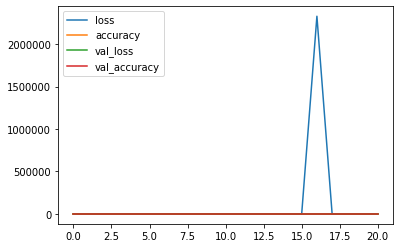

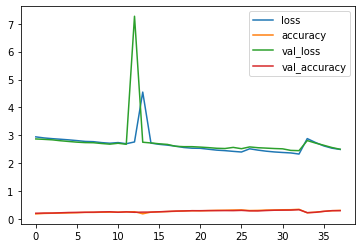

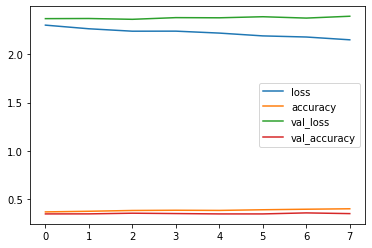

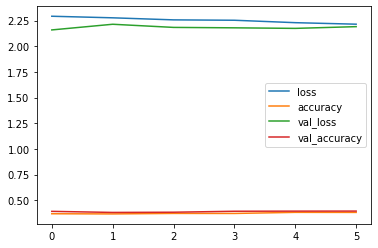

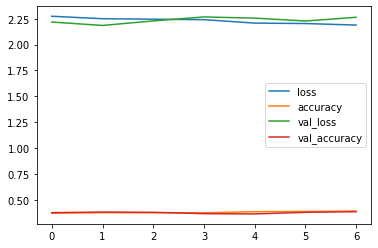

In [10]:
kfold_validation = KFold(n_splits= number_of_splits, shuffle=True, random_state=lstm_seed)

lstm_model.summary()

run_dir = os.path.join('runs', lstm_model.name)
test_data = os.path.join(run_dir, 'test_input_labels.npz')
train_data = os.path.join(run_dir, 'train_input_labels.npz')

if not os.path.exists(test_data) :
    X_test, y_test = utils.create_mfcc_array_compressed(testdf, 'test', sr= base_sr, max_len= max_len, n_mfcc=n_mfcc)
    np.savez(test_data, x_test=X_test, y_test=y_test)
if os.path.exists(test_data):
    test_arrays = np.load(test_data)
    
if not os.path.exists(train_data) :
    X, y = utils.create_mfcc_array_compressed(traindf, 'train', sr= base_sr, max_len= max_len, n_mfcc=n_mfcc)
    np.savez(train_data, x=X, y=y)
if os.path.exists(train_data):
    train_arrays = np.load(train_data)
    
input_shape = utils.mfcc_compressed_input_sizes(n_mfcc, max_len)

print(f'+-----------Training {lstm_model.name} Model-----------+')
for i, (train_split_indexes, validation_split_indexes) in enumerate(kfold_validation.split(traindf)):
    X, y = train_arrays['x'], train_arrays['y']
    X_test, y_test = test_arrays['x_test'], test_arrays['y_test']
    X_train, y_train = X[train_split_indexes], y[train_split_indexes]
    X_val, y_val = X[validation_split_indexes], y[validation_split_indexes]
    
    best_weights_file = os.path.join(run_dir, f'best_{i}.h5')
    checkpoint = ModelCheckpoint(best_weights_file, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir= os.path.join(run_dir, 'logs', f'fold_{i}'), write_graph=True)

    callbacks_list = [checkpoint, early, tb]

    y_train, y_val = pd.Series(y_train).apply(lambda x: class_indices[x]), pd.Series(y_val).apply(lambda x: class_indices[x])
    X_train, X_val = X_train.reshape(X_train.shape[0], input_shape[0], input_shape[1]), X_val.reshape(X_val.shape[0], input_shape[0], input_shape[1])
    y_test = pd.Series(y_test).apply(lambda x: class_indices[x])
    X_test= X_test.reshape(X_test.shape[0], input_shape[0], input_shape[1])
    
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    
    X_train, X_val, X_test = (X_train - mean)/std, (X_val - mean)/std, (X_test - mean)/std
    
    y_train_hot = to_categorical(y_train)
    y_val_hot = to_categorical(y_val)
    y_test_hot = to_categorical(y_test)
    
    lstm_model.fit(X_train, y_train_hot,
                callbacks=callbacks_list,
                validation_data=(X_val, y_val_hot),
                epochs=50)
    
    lstm_model.load_weights(best_weights_file)
    
    lstm_model.evaluate(X_test, y_test_hot)
    
    pred = lstm_model.predict(X_test, verbose= 1)

    np.save(os.path.join(run_dir, f'test_predictions_{i}.npy'), pred)
    
    pd.DataFrame(lstm_model.history.history).plot()

In [11]:
#Showing the obtained metrics for each model
for model in models_to_train:
    pred_list = []
    for i in range(number_of_splits):
        pred_list.append(np.load(os.path.join('runs', model.name, f'test_predictions_{i}.npy')))
    
    prediction = np.ones_like(pred_list[0])
    
    for pred in pred_list:
        prediction = prediction*pred
    prediction = prediction**(1./len(pred_list))
   
    # Generate predictions
    predicted_class_indices = np.argmax(prediction,axis=-1)
    
    labels = dict((v,k) for k,v in class_indices.items())
    predicted_labels = [labels[k] for k in predicted_class_indices]
    
    test = pd.read_csv(testdf_dir)
    test[['fname', 'label']].to_csv(os.path.join('runs', model.name, f'{model.name}_predictions.csv'), index=False)
    
    y_true = test['label']
    y_pred = predicted_labels
    
    print(f'+-----------Printing {model.name} predictions evaluation-----------+')
    print(metrics.classification_report(y_true, y_pred, digits=3))

+-----------Printing kaggle_2d_conv_pool_cnn predictions evaluation-----------+
                       precision    recall  f1-score   support

      Acoustic_guitar      0.523     0.511     0.517        45
             Applause      0.795     0.969     0.873        32
                 Bark      0.538     0.500     0.519        28
            Bass_drum      0.667     0.786     0.721        28
Burping_or_eructation      0.610     0.781     0.685        32
                  Bus      0.591     0.520     0.553        25
                Cello      0.595     0.815     0.688        54
                Chime      0.625     0.345     0.444        29
             Clarinet      0.643     0.804     0.714        56
    Computer_keyboard      0.600     0.115     0.194        26
                Cough      0.333     0.400     0.364        30
              Cowbell      0.900     0.857     0.878        42
          Double_bass      0.711     0.675     0.692        40
 Drawer_open_or_close      0.250     

C:\tools\Anaconda3\envs\vvenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time to ensemple all of our model's predictions.

In [12]:
#Ensembling all the models using Geometric mean.
pred_list = []
for i in range(number_of_splits):
    pred_list.append(np.load(os.path.join('runs', spectrogram_2d_model.name, f'test_predictions_{i}.npy')))

#As the lstm perform worse than 50%, it is not encluded in the embedding.
for model in models_to_train:
    for i in range(number_of_splits):
        if not model.name == 'lstm':
            pred_list.append(np.load(os.path.join('runs', model.name, f'test_predictions_{i}.npy')))

prediction = np.ones_like(pred_list[0])

for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))

# Generate predictions

predicted_class_indices = np.argmax(prediction,axis=-1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predicted_class_indices]

test = pd.read_csv(testdf_dir)
test[['fname', 'label']].to_csv(f'ensembled_predictions.csv', index=False)

y_true = test['label']
y_pred = predicted_labels
print(metrics.classification_report(y_true, y_pred, digits=3))

15
                       precision    recall  f1-score   support

      Acoustic_guitar      0.756     0.756     0.756        45
             Applause      0.842     1.000     0.914        32
                 Bark      0.929     0.929     0.929        28
            Bass_drum      0.758     0.893     0.820        28
Burping_or_eructation      1.000     1.000     1.000        32
                  Bus      0.947     0.720     0.818        25
                Cello      0.783     0.870     0.825        54
                Chime      0.727     0.552     0.627        29
             Clarinet      0.765     0.929     0.839        56
    Computer_keyboard      0.929     0.500     0.650        26
                Cough      0.839     0.867     0.852        30
              Cowbell      0.927     0.905     0.916        42
          Double_bass      0.872     0.850     0.861        40
 Drawer_open_or_close      0.724     0.724     0.724        29
       Electric_piano      0.862     0.781     0.82